# wk6 Demo - Supplement
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

This week's lesson focused on understanding Gradient Descent as the seminal application of optimization theory. The main demo notebook walked you through a few exercizes to illustrate core concepts. This notebook includes supplemental code related to gradient descent and linear regression.


## Notebook Set Up

In [15]:
# general imports
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# A Bigger Example

Ok, now that we have a handle on the math and the basic design choices involved in implementing & parallelizing Gradient Descent. Lets look at a slightly bigger example: the boston housing prices dataset.

In [16]:
# ML modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [21]:
# set style for plotting
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [22]:
# we'll also fix the random seed for reproducibility
np.random.seed(42)

## Boston House Prices Dataset

Boston dataset is extremely common in machine learning experiments thus it is embedded in sklearn. Run the next few cells to load the data and become familiar with it.

In [23]:
# Load the data & take a look.
from sklearn.datasets import load_boston
boston = load_boston()

In [24]:
# OPTIONAL - view description
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [25]:
# Create data frame & test/train split.
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Take a look
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Exploratory Data Analysis

Before we jump into our linear regression, its good to become familiar with the variables you will be modeling.

In [27]:
# Summary statistics
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Note that some of the features are catecorical and some are continious.

Let's also take a look at a correlation matrix of features.

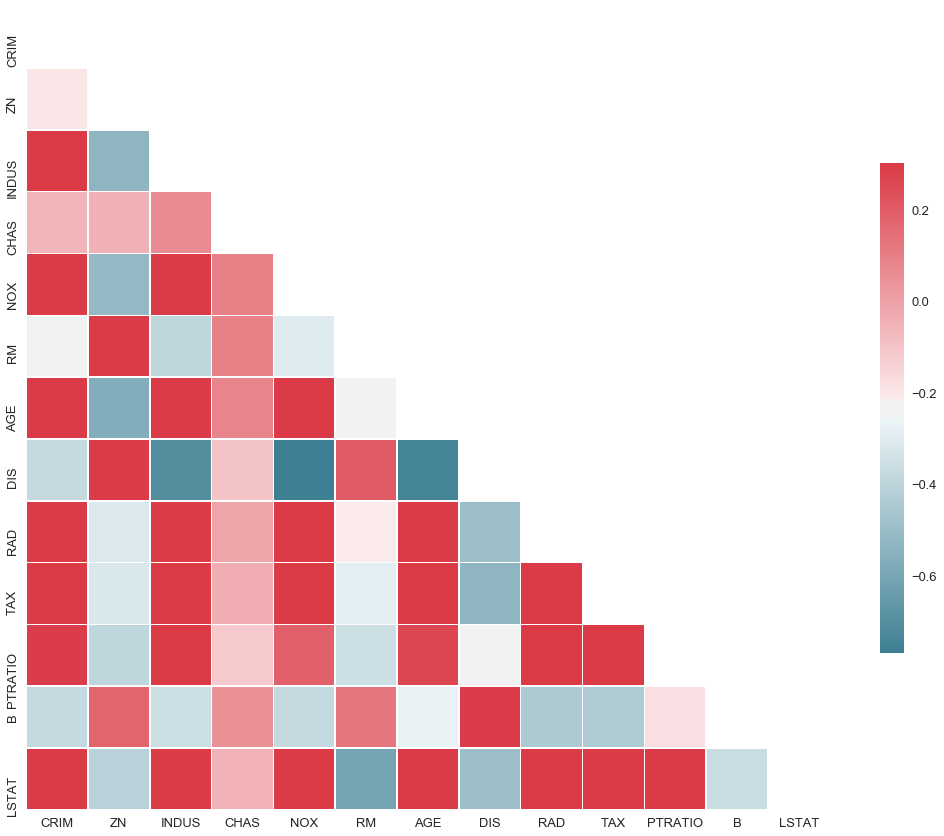

In [28]:
# compute the correlation matrix
corr = X.corr()

# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.show()

## Scaling

Once we start performing gradient descent on real world data, a few additional concerns arise. 

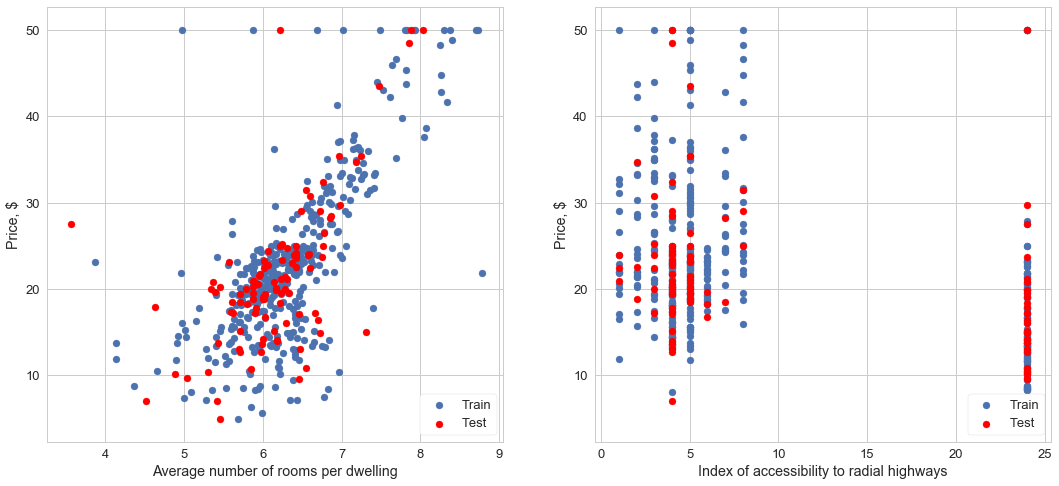

In [29]:
# Lets visualize two of the features from the Boston Dataset
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right")
plt.show()

> __DISCUSSION QUESTION:__ What will happen in the Gradient Descent update step when you have input variables that are measured on very different scales? What could we do to avoid this problem?

As you probably realized, the easiest solution is to perform normalization before we start modeling. Here we'll normalize each feature so that all $x_{ji} \in (0,1)$.

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

Note that we're going to learn normalization constants only on training set. That's done because the assumption is that test set is unreachable during training. However once we've got our normalization functions, we'll also aply them to the test set.

In [31]:
X_test = scaler.transform(X_test)

# Sklearn Linear Regression

Here we use very simple Linear Regression model. Scikit-learn uses the closed-form solition for Linear Regression problem thus it gives very good results.

## Fitting

In [32]:
# initialize the model
model_sk = LinearRegression()

# fit the data
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
# run our model to predict the test and train sets for evaluation
preds_test = model_sk.predict(X_test)
preds_train = model_sk.predict(X_train)

## Evaluation

Let's see what features are significant for the model

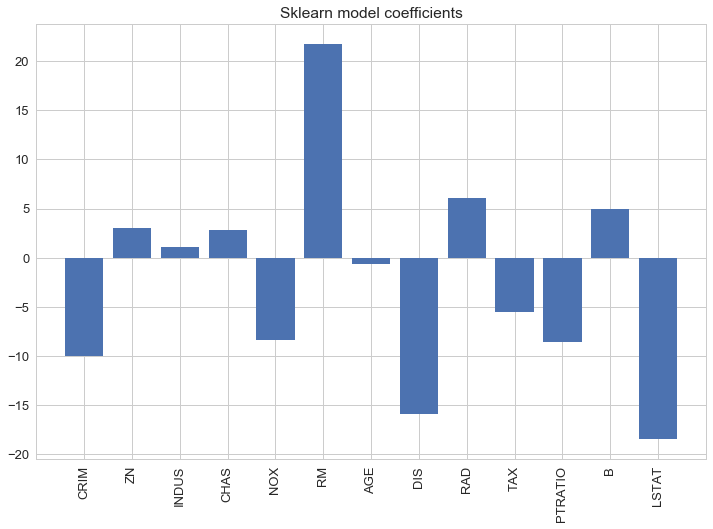

In [34]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]), model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients")
plt.show()

Next we'll evaluate our model according to three different metrics: 
* MAE (Mean Absolute Error)
* RMSE (Root Mean Squared Error)
* MAPE (Mean Absolute Percentage Error)

Note that there is no MAPE implementation in sklearn & that this is a problematic metric because it is prone to ZeroDivisionErrors. However for today's illustration we have included a custom implementation in the supplemental file `linRegFunc.py`. 

In [35]:
# define a function
def evaluate(models, metrics, samples, metrics_names, models_names):
    """
    This function runs Linear Regression Evaluation metrics 
    by looping over a provided set of models and datasets.
    """
    results = np.zeros((len(samples) * len(models), len(metrics)))
    samples_names = []
    for m in models_names:
        samples_names.extend([m + " Train", m + " Test"])
    for m_num, model in enumerate(models):
        for row, sample in enumerate(samples):
            for col, metric in enumerate(metrics):
                results[row + m_num * 2, col] = metric(sample[1], model.predict(sample[0]))
    results = pd.DataFrame(results, columns=metrics_names, index=samples_names)
    return results

In [36]:
# define metrics to run
metrics = [mean_absolute_error, 
           lambda y_true, y_pred: mean_squared_error(y_true, y_pred) ** 0.5, 
           linRegFunc.mean_absolute_percentage_error]
metrics_names = ["MAE", 
                 "RMSE", 
                 "MAPE"]

# define data sets & models to run on
samples = [(X_train, y_train), 
           (X_test, y_test)]
models_names = ["Sklearn"]
models = [model_sk]

In [37]:
# function call
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585


It also interesting to take a look how the predicted points relate to real ones. All the points should lie on the black dotted line ($y=x$) assuming that our model is perfect.

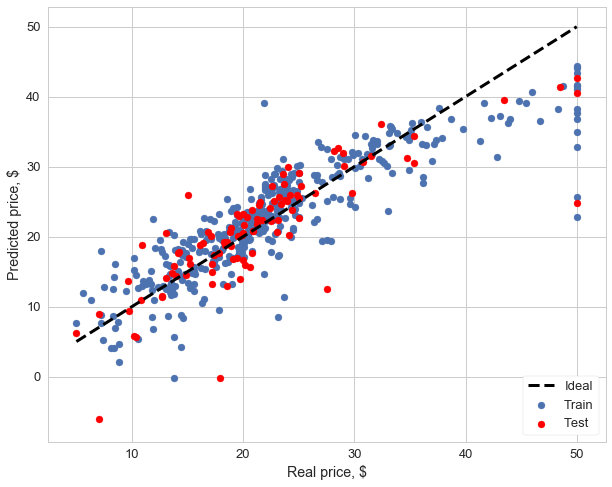

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(y_train, preds_train, label="Train")
plt.scatter(y_test, preds_test, c="r", label="Test")
plt.xlabel("Real price, $")
plt.ylabel("Predicted price, $")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label="Ideal")
plt.legend(loc="lower right")
plt.show()

## Cross-validation

The common method to evaluate the model is cross-validation. The idea behind it is to divide the whole set of objects into $k$ sections and then use one section as a test set and other $k-1$ as a train (repeat it with all the sections).

There is a special function for this in sklearn called $\text{KFold}$. It creates set of indices for cross-validation.

In [39]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Next step is to do everything that we've done before in a loop:
* Split
* Scale
* Train
* Evaluate

And store the average value of the errors ($\text{res}$ variable)

In [40]:
cv.split(X, y=None, groups=None)

<generator object _BaseKFold.split at 0x1a16a77a40>

In [41]:
res = None
for train_idx, test_idx in cv.split(X, y=None, groups=None):
    # split
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # scale
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    samples_cv = [(X_train, y_train), 
                  (X_test, y_test)]
    
    # fit
    model_sk_cv = LinearRegression().fit(samples_cv[0][0], samples_cv[0][1])
    
    # evaluate
    if res is None:
        res = evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
    else:
        res += evaluate([model_sk_cv], metrics, samples_cv, metrics_names, ["Sklearn CV"])
# take the average value across all folds
res /= cv.n_splits

Here is the result of CV

In [42]:
res

,MAE,RMSE,MAPE
Sklearn CV Train,3.269853,4.660627,16.423244
Sklearn CV Test,3.390748,4.843271,17.026372


# Homegrown Linear Regresssion

In this section we'll write our own Linear Regression class that performs gradient descent. This class will use numpy for efficient matrix calculations. Recall that the matrix representation of our loss functions is: 

$$
f(\boldsymbol{\theta}) = \frac{1}{n}\|\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\|_2^2
$$

Then the gradient can be easily calculated in vectorized form:

$$
\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\text{X}'^{\text{T}}\left(\text{X}'\cdot \boldsymbol{\theta} - \mathbf{y}\right)
$$

Exactly these computations are implemented down below in **BasicLinearRegressionHomegrown** class

In [43]:
class BasicLinearRegressionHomegrown(object):
    
    def __init__(self):
        self.coef_ = None       # weight vector
        self.intercept_ = None  # bias term
        self._theta = None      # augmented weight vector, i.e., bias + weights
                                # this allows to treat all decision variables homogeneously
        self.history = {"cost": [], 
                        "coef": [], 
                        "intercept": [], 
                        "grad": []}
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        return gradient
    
    # full gradient descent, i.e., not stochastic gd
    def _gd(self, X, y, max_iter, alpha):
        """
        Runs GD and logs error, weigths, gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            # calculate gradient
            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            # do gradient step
            self._theta -= alpha * grad
    
    def fit(self, X, y, max_iter, alpha):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of weight updates
        Return:
            self
        """
        # Augment the data with the bias term.
        # So we can treat the the input variables and the bias term homogeneously 
        # from a vectorization perspective
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize if the first step
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])
        
        # do full gradient descent
        self._gd(X, y, max_iter, alpha)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]
        return self
        
    def score(self, X, y):
        """
        Calculate RMSE metric

        Args:
            X(ndarray):      objects
            y(ndarray):      answers
        Return:
            rmse(float):     RMSE
        """
        pred = self.predict(X)
        error = pred - y
        rmse = (np.sum(error ** 2) / X.shape[0]) ** 0.5
        return rmse
        
    def predict(self, X):
        """
        Make a prediction

        Args:
            X(ndarray):      objects
        Return:
            pred(ndarray):   predictions
        """
        # check whether X has appended bias feature or not
        if X.shape[1] == len(self._theta):
            pred = np.dot(X, self._theta)
        else:
            pred = np.dot(X, self.coef_) + self.intercept_
        return pred

__Create model__

In [44]:
model_homegrown = BasicLinearRegressionHomegrown()

__Fitting__

In [45]:
model_homegrown.fit(X_train, y_train, max_iter=100, alpha=0.001)

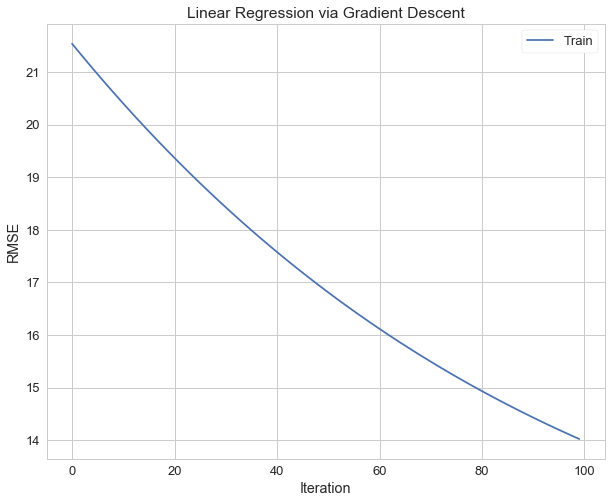

In [46]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Gradient Descent")
plt.legend()
plt.show()

__Evaluation__

In [47]:
models = [model_sk, model_homegrown]
models_names = ["Sklearn", "Homegrown"]

In [48]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,11.125454,14.212790,44.340562
Homegrown Test,9.733487,12.704141,42.076697


## Numerical check
In the last section **BasicLinearRegressionHomegrown** class provides you with the method *_grad* that allows to compute analytical gradient. This function is correct. However with more complicated Loss Functions we may run the risk of making a mistake. In this section we'll look at a simple way to check that our gradient function is right.

The formula for analytical gradient (from calculus):

$$
\nabla f(\mathbf{x}) = 
\begin{bmatrix}
\frac{\partial f}{\partial x_1}\\
\vdots\\
\frac{\partial f}{\partial x_m}
\end{bmatrix}, \text{ where } m \text{ is the space dimension}\\
\frac{\partial f}{\partial x_1} = \lim_{\alpha \rightarrow 0} \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha}
$$

For sufficiently small $\alpha$ one can approximate partial derivative by simple throwing out the limit operator

$$
\frac{\partial f}{\partial x_1} \approx \frac{f(x_1 + \alpha, x_2 \ldots x_m) - f(x_1, x_2 \ldots x_m)}{\alpha} = \left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
$$

Then the final approximation of the gradient is:

$$
\nabla f(\mathbf{x}) \approx \nabla_{\text{num}\,\,} f(\mathbf{x}) = \begin{bmatrix}
\left( \frac{\partial f}{\partial x_1} \right)_{\text{num}}\\
\vdots\\
\left( \frac{\partial f}{\partial x_m} \right)_{\text{num}}
\end{bmatrix}
$$

The common way of measuring the difference between vectors is the following:
$$
\text{er} = \frac{\|\nabla f(\mathbf{x}) - \nabla_{\text{num}\,\,}f(\mathbf{x})\|_2^2}{\|\nabla f(\mathbf{x})\|_2^2} = \frac{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x}) - \nabla^j_{\text{num}\,\,}f(\mathbf{x})\right)^2}{\sum_{j=1}^{m}\left(\nabla^j f(\mathbf{x})\right)^2}
$$

The next class, **TweakedLinearRegressionHomegrown**, inherits from **BasicLinearRegressionHomegrown** and adds a method for numerical approximation of gradient. Next we'll 
* Check our approximation function by comparing with the analytical one. They **should** be similar.
* Plot the difference of analytical and numerical gradients and describe what we observe.

In [49]:
class TweakedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(TweakedLinearRegressionHomegrown, self).__init__()
        self.history["grad_num"] = []
        
    @staticmethod
    def _gradient_approximation(f, x):
        """
        Returns the numerical gradient of the function f at the point x

        Args:
            f(callable): function that takes the point x as an input 
                         and returns the value of the function
            x(ndarray): numpy array which contains the coordinates 
                        of the point to evaluate gradient
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """

        grad_num = np.zeros(len(x))

        alpha = 0.001
        for i in range(len(x)):
            h = np.zeros(len(x))
            h[i] += alpha
            grad_num[i] = (f(x + h) - f(x)) / alpha

        return grad_num
    
    def _grad_num(self, X, y):
        """
        Returns the numerical gradient of the LinearRegression 
        objective function

        Args:
            X(ndarray): train objects
            y(ndarray): answers for train objects
        Return:
            grad_num(ndarray): the numerical approximation 
                               of the gradient
        """
        
        grad_num = np.zeros(X.shape[1])
        
        def f(a):
            pred = np.dot(X, a)
            error = pred - y
            mse = np.mean(error ** 2)
            return mse
            
        
        grad_num = self._gradient_approximation(f, self._theta)
        
        return grad_num
    
    def _gd(self, X, y, max_iter, alpha):
        """
        Runs GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        for i in range(max_iter):
            self.history["coef"].append(self._theta[1:].copy())
            self.history["intercept"].append(self._theta[0].copy())
            
            rmse = self.score(X, y)
            self.history["cost"].append(rmse)

            grad = self._grad(X, y)
            self.history["grad"].append(grad)
            
            grad_num = self._grad_num(X, y)
            self.history["grad_num"].append(grad_num)
            
            self._theta -= alpha * grad

Create model

In [50]:
model_homegrown_check_grad = TweakedLinearRegressionHomegrown()

Fitting

In [51]:
model_homegrown_check_grad.fit(X_train, y_train, max_iter=100, alpha=0.001)

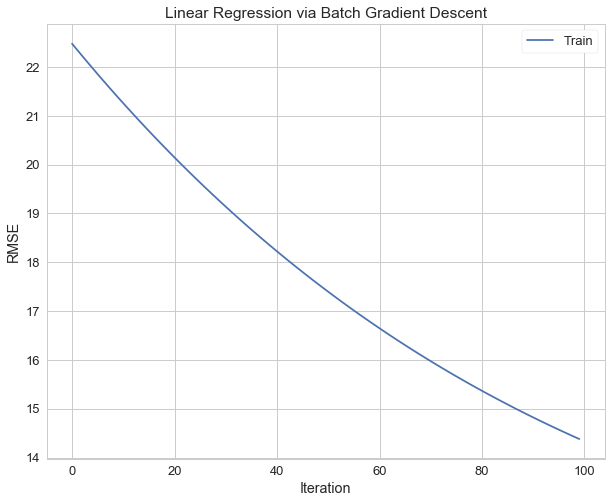

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_check_grad.history["cost"], label="Train")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.title("Linear Regression via Batch Gradient Descent")
plt.legend(frameon=True)
plt.show()

Plotting error curves

In [53]:
grad_num = np.array(model_homegrown_check_grad.history["grad_num"])
grad = np.array(model_homegrown_check_grad.history["grad"])

In [54]:
def relative_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1. / np.sum(grad ** 2, axis=1)

In [55]:
def absolute_error(grad, grad_num):
    return np.sum((grad - grad_num) ** 2, axis=1) * 1.

In [56]:
pd.DataFrame(absolute_error(grad, grad_num)).describe()

,0
count,1.000000e+02
mean,2.599855e-06
std,2.973209e-13
min,2.599855e-06
25%,2.599855e-06
50%,2.599855e-06
75%,2.599855e-06
max,2.599856e-06


In [57]:
absolute_error(grad, grad_num)[:2]

array([2.59985569e-06, 2.59985539e-06])

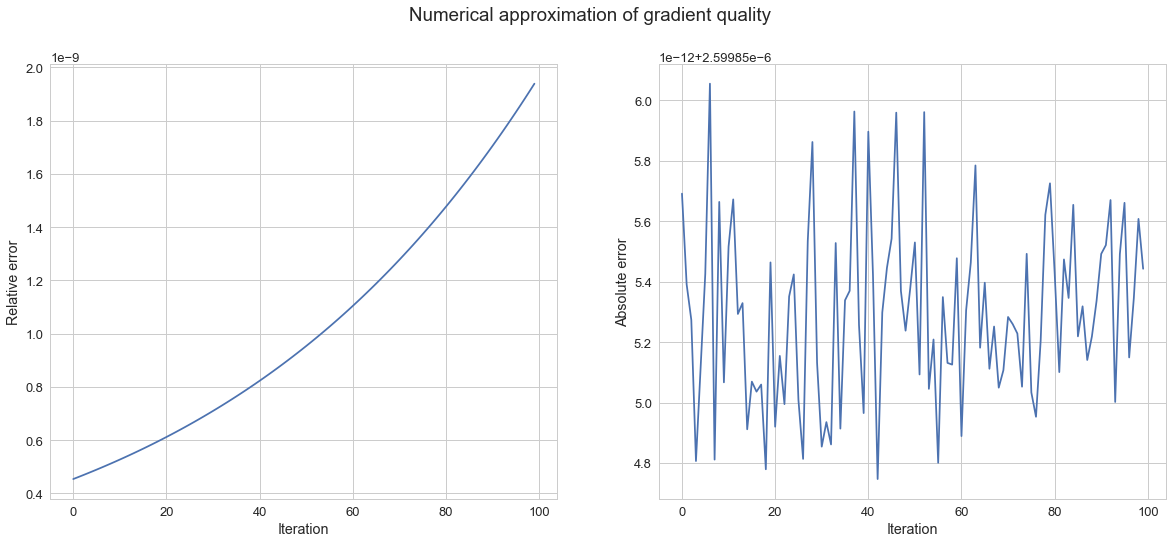

In [58]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

As one can observe absolute error jitters but remains approximately the same during all the trining process. The big values in the beginning is due to the fact that the values of gradient is also big.

Relative error grows because the norm of the gradient (which is in the denominator) becomes smaller while the optimization process converges.

## Stochastic Gradient Descent

In section 3 we suggested that we can get faster convergence if we calculate the gradient not over the whole set of data but over the small (size of $B$) **batch** of it. However with our small dataset this didn't seem to be the case. Let's take a second look now that we are working on a more realistic dataset.

Recall the gradient calculation for Stoichastic Gradient Descent:

\begin{equation}\tag{3.2}
\nabla f(\boldsymbol{\theta}) \approx \nabla_{\text{batch}\,\,} f(\boldsymbol{\theta}) = \frac{2}{n}\sum_{i=1}^{B}\left(\mathbf{x}'_{a_i}\cdot \boldsymbol{\theta} - y_{a_i}\right)\cdot \mathbf{x}'_{a_i}
\end{equation}

where $a_i$ is an array of indices of objects which are in this batch. 

The next class **StochasticLinearRegressionHomegrown**, inherits from **TweakedLinearRegressionHomegrown** to stochastic gradient descent algorithm as a member of a class. As before, we'll check that analytical gradient is right via numerical gradient function from **TweakedLinearRegressionHomegrown**.

In [59]:
len(X)

506

In [60]:
class StochasticLinearRegressionHomegrown(TweakedLinearRegressionHomegrown):
    
    def __init__(self):
        # call the constructor of the parent class
        super(StochasticLinearRegressionHomegrown, self).__init__()
    
    def _sgd(self, X, y, max_iter, batch_size, alpha):
        """
        Runs Stochastic GD and logs error, weigths, gradient and 
        numerical gradient at every step

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
            alpha(floar):    step size in direction of gradient
        Return:
            None
        """
        
        for epoch in range(max_iter):
            idxs = np.random.permutation(X.shape[0])
            X = X[idxs]
            y = y[idxs]
            for i in range(0, len(X), batch_size):
                
                self.history["coef"].append(self._theta[1:].copy())
                self.history["intercept"].append(self._theta[0].copy())
                
                rmse = self.score(X, y)
                self.history["cost"].append(rmse)
                
                # calculate gradient
                grad = self._grad(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad"].append(grad)
                
                # numerical gradient
                grad_num = self._grad_num(X[i:i + batch_size], y[i:i + batch_size])
                self.history["grad_num"].append(grad_num)
            
                # do gradient step
                self._theta -= alpha * grad
        
    def fit(self, X, y, max_iter, batch_size, alpha):
        """
        Public API for fitting a linear regression model

        Args:
            X(ndarray):      train objects
            y(ndarray):      answers for train objects
            max_iter(int):   number of EPOCHS, i.e., full passes over data
            batch_size(int): number of samples in one batch
        Return:
            self
        """
        X = np.c_[np.ones(X.shape[0]), X]
        if self._theta is None:
            self._theta = np.random.rand(X.shape[1])

        self._sgd(X, y, max_iter, batch_size, alpha)
        
        self.intercept_ = self._theta[0]
        self.coef_ = self._theta[1:]

Create model

In [61]:
model_homegrown_sgd = StochasticLinearRegressionHomegrown()

Fitting

In [68]:
model_homegrown_sgd.fit(X_train, y_train, batch_size=1, max_iter=100, alpha=0.001)

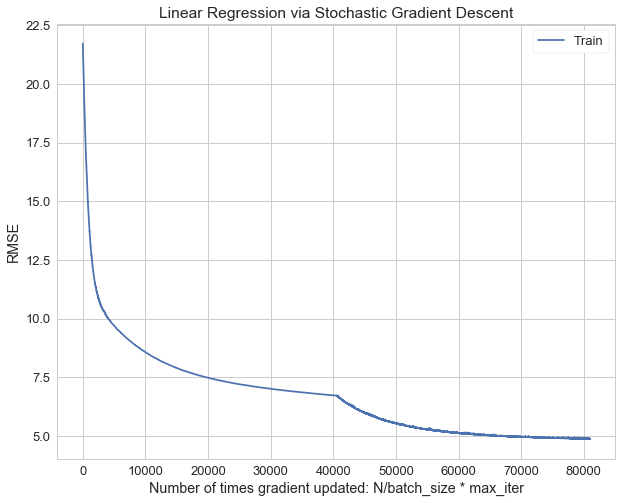

In [69]:
plt.figure(figsize=(10, 8))
plt.plot(model_homegrown_sgd.history["cost"], label="Train")
plt.xlabel("Number of times gradient updated: N/batch_size * max_iter")
plt.ylabel("RMSE")
plt.title("Linear Regression via Stochastic Gradient Descent")
plt.legend(frameon=True)
plt.show()

Plotting error curves

In [70]:
grad_num = np.array(model_homegrown_sgd.history["grad_num"])
grad = np.array(model_homegrown_sgd.history["grad"])

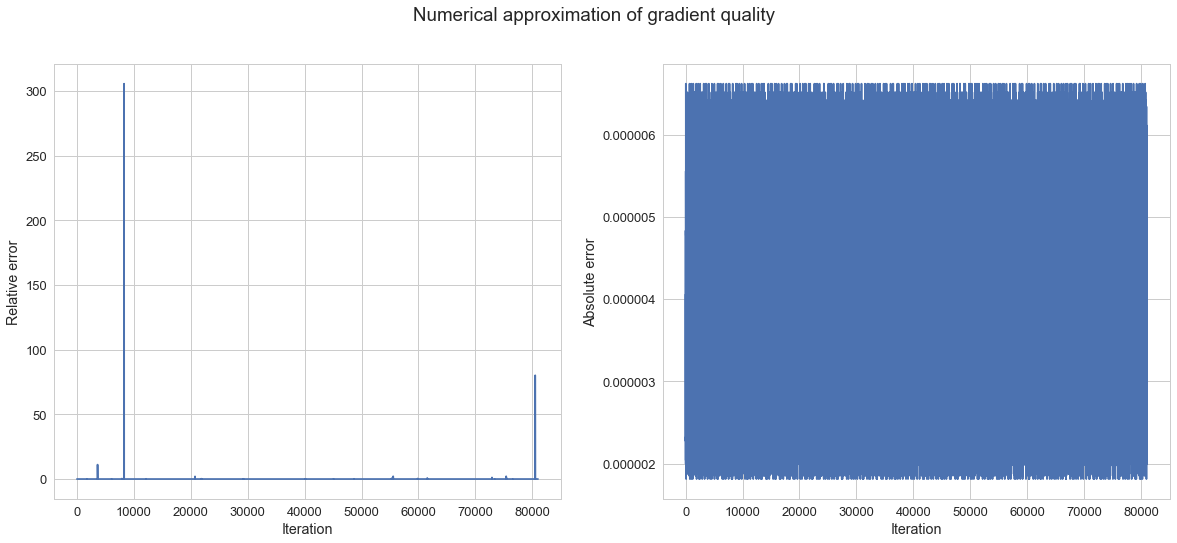

In [71]:
plt.figure(figsize=(20, 8))
plt.suptitle("Numerical approximation of gradient quality")
plt.subplot(121)
plt.plot(relative_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.subplot(122)
plt.plot(absolute_error(grad, grad_num))
plt.xlabel("Iteration")
plt.ylabel("Absolute error")
plt.show()

Evaluation

In [72]:
models = [model_sk, model_homegrown, model_homegrown_sgd]
models_names = ["Sklearn", "Homegrown Full GD", "Homegrown SGD"]

In [73]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Full GD Train,11.125454,14.212790,44.340562
Homegrown Full GD Test,9.733487,12.704141,42.076697
Homegrown SGD Train,3.302384,4.874682,16.277540
Homegrown SGD Test,2.976680,5.078497,15.681669


## L1 and L2 regularization for Linear Regression
Regularization is a way of penalizing the model for excessive complexity. It allows us to avoid overfitting.

There are many ways of doing regularization but these two are the major ones:
* **L2-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}w_j^2
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_2^2
$$
* **L1-regularization:**
$$
f(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^{n}\left[ (\mathbf{w}\cdot\mathbf{x}_i + b) - y_i\right]^2 + \lambda \sum_{j=1}^{m}|w_j|
$$
or in matrix way:
$$
f(\mathbf{w}, b) = \|\text{X}\cdot\mathbf{w} + b\cdot\mathbf{1}_n - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1
$$

The class below, **RegularizedLinearRegressionHomegrown**, inherits from 
**BasicLinearRegressionHomegrown** and encorporates both regularization strategies into the GD solution of Linear Regression. Below we'll examine the problem that arises with L1-regularization as well as its benefits.

In [91]:
class RegularizedLinearRegressionHomegrown(BasicLinearRegressionHomegrown):
    
    def __init__(self, l1_reg=0.0, l2_reg=0.0):
        # call the constructor of the parent class
        super(RegularizedLinearRegressionHomegrown, self).__init__()
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
    def _grad(self, X, y):
        """
        Calculate the gradient of the objective function 
        with L1 and L2 regularizations

        Args:
            X(ndarray):        train objects
            y(ndarray):        answers for train objects
        Return:
            gradient(ndarray): analytical gradient vector
        """
        pred = np.dot(X, self._theta)
        error = pred - y
        gradient = 2 * np.dot(error, X) / X.shape[0]
        # penalties only for weights
        gradient[1:] += 2 * self.l2_reg * self._theta[1:] + self.l1_reg * np.sign(self._theta[1:])
        return gradient

Create model

In [92]:
model_homegrown_regularized_l2 = RegularizedLinearRegressionHomegrown(l1_reg=0.0, l2_reg=0.1)
model_homegrown_regularized_l1 = RegularizedLinearRegressionHomegrown(l1_reg=1.0, l2_reg=0.0)

Fitting

In [93]:
model_homegrown_regularized_l2.fit(X_train, y_train, max_iter=40000)
model_homegrown_regularized_l1.fit(X_train, y_train, max_iter=40000)

Evaluation

In [94]:
models = [model_sk, model_homegrown, model_homegrown_regularized_l2, model_homegrown_regularized_l1]
models_names = ["Sklearn", "Homegrown", "Homegrown Regularized L2", "Homegrown Regularized L1"]

In [95]:
evaluate(models, metrics, samples, metrics_names, models_names)

,MAE,RMSE,MAPE
Sklearn Train,3.315165,4.652051,16.573489
Sklearn Test,3.191509,4.930662,16.880585
Homegrown Train,3.553939,5.215440,16.997004
Homegrown Test,3.163314,5.182396,16.636239
Homegrown Regularized L2 Train,4.538807,6.663758,21.517049
Homegrown Regularized L2 Test,3.895744,5.969197,20.338186
Homegrown Regularized L1 Train,4.463647,6.509919,21.737358
Homegrown Regularized L1 Test,3.905801,6.069943,20.587212


Comparison of regularized models

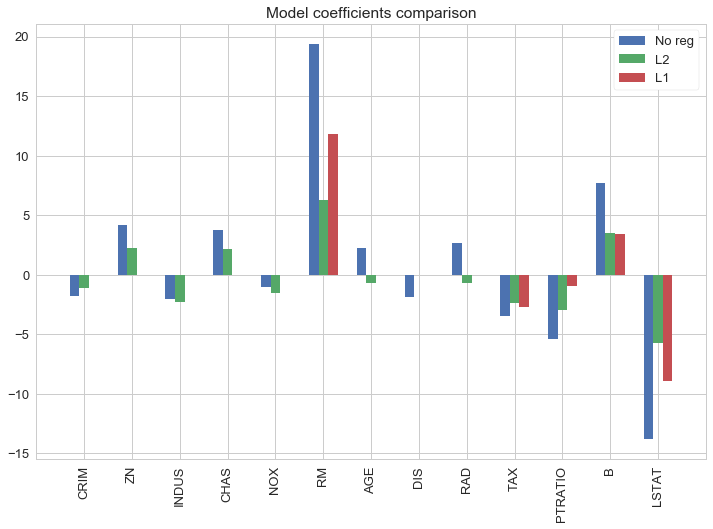

In [96]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_homegrown.coef_.shape[0]) - 0.2, model_homegrown.coef_, width=0.2, label="No reg")
plt.bar(np.arange(model_homegrown_regularized_l2.coef_.shape[0]), model_homegrown_regularized_l2.coef_, width=0.2, label="L2")
plt.bar(np.arange(model_homegrown_regularized_l1.coef_.shape[0]) + 0.2, model_homegrown_regularized_l1.coef_, width=0.2, label="L1")
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Model coefficients comparison")
plt.legend()
plt.show()

In [97]:
print("2-norm of weights:\n")
print("{:10s}{:.2f}".format("No reg:", np.linalg.norm(model_homegrown.coef_)))
print("{:10s}{:.2f}".format("L2:", np.linalg.norm(model_homegrown_regularized_l2.coef_)))
print("{:10s}{:.2f}".format("L1:", np.linalg.norm(model_homegrown_regularized_l1.coef_)))

2-norm of weights:

No reg:   26.86
L2:       10.92
L1:       15.43


In [98]:
print("Number of non-zero coefficients:\n")
print("{:10s}{:d}".format("No reg:", np.sum(np.abs(model_homegrown.coef_) > 1e-2)))
print("{:10s}{:d}".format("L2:", np.sum(np.abs(model_homegrown_regularized_l2.coef_) > 1e-2)))
print("{:10s}{:d}".format("L1:", np.sum(np.abs(model_homegrown_regularized_l1.coef_) > 1e-2)))

Number of non-zero coefficients:

No reg:   13
L2:       13
L1:       5


As one can notice L2-regularization greatly reduces the 2-norm of weight vector thereby it prevents overfitting. Regularization constant can be used to control [bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).

L1-regularization plays the same role but it also has one very important prorepty: it can work as a feature selector (impose sparsity on the coefficient vector). From mathematical perspective it can be explained as follows: L1-norm is the "closest" approximation to the L0-norm which explicitly equals to the number of non-zero elements. For sure, the ideal feature selector is L0-norm but one can not simply minimize it because of its computationally intractability (due to its combinatorial nature). Thus people usually use L1-norm for that purpose. More intuitive geometrical interpretation can be found [here](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2) or in any other source (lots of them). For more detailed and deep mathematical explanation one can take a look into [compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing) method introduced by Terence Tao and David Donoho in the early 2000's.

__A couple nice videos by Ritvik Kharkar:__


Ridge regression:
https://www.youtube.com/watch?v=5asL5Eq2x0A

Lasso regression:
https://www.youtube.com/watch?v=jbwSCwoT51M